In [38]:
import pandas as pd
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_groq import ChatGroq
from langchain_community.chat_models import ChatOpenAI
from langchain.docstore.document import Document
from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_community.vectorstores import chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEndpoint
from langchain import HuggingFacePipeline
from transformers import pipeline
# RAG Chain
from langchain_core.output_parsers import StrOutputParser
from langchain.chains import RetrievalQA
from transformers import AutoModelForCausalLM,AutoTokenizer
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
from langchain import HuggingFacePipeline
import transformers
import torch  
import os
from langchain_huggingface import HuggingFaceEmbeddings

In [39]:
crop_folders = os.listdir(r".\data")

In [40]:
crop_folders

['Apple', 'Coconut', 'Paddy', 'Potato', 'Tomato']

In [41]:
import os
import pandas as pd

# Path where these folders are located
base_path = r".\data"   # <-- change this to your actual root directory

# Empty list to hold all DataFrames
dfs = []

# Loop through each folder
for folder in crop_folders:
    folder_path = os.path.join(base_path, folder)
    
    # Ensure folder exists
    if os.path.isdir(folder_path):
        # Loop through files in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):   # only process CSV files
                file_path = os.path.join(folder_path, file)
                df = pd.read_csv(file_path)
                
                df["disease_name"] = os.path.splitext(file)[0].split(folder + "_")[1].replace("_"," ")
                
                dfs.append(df)

# Concatenate all DataFrames into one big DataFrame
big_df = pd.concat(dfs, ignore_index=True)

# print(big_df.shape)
# print(big_df.head())


C:\Users\HP\AppData\Local\Temp\ipykernel_27724\2359651815.py:20: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\HP\AppData\Local\Temp\ipykernel_27724\2359651815.py:20: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\HP\AppData\Local\Temp\ipykernel_27724\2359651815.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(dfs, ignore_index=True)


In [42]:
big_df.columns

Index(['BlockName', 'Category', 'Year', 'Month', 'Day', 'Crop', 'DistrictName',
       'QueryType', 'Season', 'Sector', 'StateName', 'QueryText', 'KccAns',
       'latitude', 'longitude', 'disease_name'],
      dtype='object')

In [43]:
big_df.head(2)

,BlockName,Category,Year,Month,Day,Crop,DistrictName,QueryType,Season,Sector,StateName,QueryText,KccAns,latitude,longitude,disease_name
0,0,0,2010,6,23,Apple,ANANTNAG,0,JAYAD,HORTICULTURE,JAMMU AND KASHMIR,CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREE,KEEP 60 CM SOIL AROUND TREES TRUNKS UNDISTURDED ON-SEASON,33.7461,75.1854,Alternaria leaf blotch
1,0,0,2010,6,18,Apple,BARAMULLA,0,JAYAD,HORTICULTURE,JAMMU AND KASHMIR,FARMER WANTS INFORMATION ABOUT THE CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREES,THE CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREES IS TO SPRAY WITH BITERTANOL 25 EC 50G100LTRS OF WATER,34.2087,74.3435,Alternaria leaf blotch


In [44]:
len(big_df)

598706

In [45]:
big_df.isna().sum()

BlockName            3
Category             0
Year                 0
Month                0
Day                  0
Crop                 0
DistrictName         0
QueryType        34267
Season          378605
Sector               0
StateName            0
QueryText            0
KccAns           75713
latitude             0
longitude            0
disease_name         0
dtype: int64

In [46]:
big_df[big_df["KccAns"].isna()].head(2)

,BlockName,Category,Year,Month,Day,Crop,DistrictName,QueryType,Season,Sector,StateName,QueryText,KccAns,latitude,longitude,disease_name
2,QAZIGUND,Fruits,2019,7,31,Apple,ANANTNAG,Plant Protection,NaN,HORTICULTURE,JAMMU AND KASHMIR,REGARDING ALTERNARIA LEAF BLOTCH IN APPLE,NaN,33.7461,75.1854,Alternaria leaf blotch
3,DACHNIPORA,Fruits,2019,8,2,Apple,ANANTNAG,Plant Protection,NaN,HORTICULTURE,JAMMU AND KASHMIR,REGARDING ALTERNARIA LEAF BLOTCH IN APPLE,NaN,33.7461,75.1854,Alternaria leaf blotch


In [47]:
big_df = big_df.dropna(subset="KccAns")

In [48]:
big_df = big_df.rename(columns={"Season English": "Season_English"})

In [49]:
big_df.head(2)

,BlockName,Category,Year,Month,Day,Crop,DistrictName,QueryType,Season,Sector,StateName,QueryText,KccAns,latitude,longitude,disease_name
0,0,0,2010,6,23,Apple,ANANTNAG,0,JAYAD,HORTICULTURE,JAMMU AND KASHMIR,CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREE,KEEP 60 CM SOIL AROUND TREES TRUNKS UNDISTURDED ON-SEASON,33.7461,75.1854,Alternaria leaf blotch
1,0,0,2010,6,18,Apple,BARAMULLA,0,JAYAD,HORTICULTURE,JAMMU AND KASHMIR,FARMER WANTS INFORMATION ABOUT THE CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREES,THE CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREES IS TO SPRAY WITH BITERTANOL 25 EC 50G100LTRS OF WATER,34.2087,74.3435,Alternaria leaf blotch


In [50]:
import calendar
big_df["Month"] = big_df["Month"].apply(lambda x: calendar.month_name[x])

In [51]:
big_df.head(2)

,BlockName,Category,Year,Month,Day,Crop,DistrictName,QueryType,Season,Sector,StateName,QueryText,KccAns,latitude,longitude,disease_name
0,0,0,2010,June,23,Apple,ANANTNAG,0,JAYAD,HORTICULTURE,JAMMU AND KASHMIR,CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREE,KEEP 60 CM SOIL AROUND TREES TRUNKS UNDISTURDED ON-SEASON,33.7461,75.1854,Alternaria leaf blotch
1,0,0,2010,June,18,Apple,BARAMULLA,0,JAYAD,HORTICULTURE,JAMMU AND KASHMIR,FARMER WANTS INFORMATION ABOUT THE CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREES,THE CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREES IS TO SPRAY WITH BITERTANOL 25 EC 50G100LTRS OF WATER,34.2087,74.3435,Alternaria leaf blotch


In [52]:
len(big_df)

522993

In [53]:
big_df.columns

Index(['BlockName', 'Category', 'Year', 'Month', 'Day', 'Crop', 'DistrictName',
       'QueryType', 'Season', 'Sector', 'StateName', 'QueryText', 'KccAns',
       'latitude', 'longitude', 'disease_name'],
      dtype='object')

In [54]:
big_df = big_df[["DistrictName","StateName","Season","Month","disease_name","QueryText","KccAns","Crop"]]

In [55]:
big_df.head(3)

,DistrictName,StateName,Season,Month,disease_name,QueryText,KccAns,Crop
0,ANANTNAG,JAMMU AND KASHMIR,JAYAD,June,Alternaria leaf blotch,CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREE,KEEP 60 CM SOIL AROUND TREES TRUNKS UNDISTURDED ON-SEASON,Apple
1,BARAMULLA,JAMMU AND KASHMIR,JAYAD,June,Alternaria leaf blotch,FARMER WANTS INFORMATION ABOUT THE CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREES,THE CONTROL OF ALTERNARIA LEAF BLOTCH IN APPLE TREES IS TO SPRAY WITH BITERTANOL 25 EC 50G100LTRS OF WATER,Apple
23,ANANTNAG,JAMMU AND KASHMIR,NaN,July,Alternaria leaf blotch,Farmer asked the query regarding problem alternaria leaf blotch in apple,It is advised to the farmer spray one of the following fungicides at fruit development stage 3rd Mancozeb 75 WP 300 g or Ziram 27 SC 600 ml or Zineb 75 WP 300 g or Ziram 80 WP 200 g or Chlorothalonil 75 WP 150 g In case rainy weather hampers VII FD II spray Difenaconazole 25 EC 30 ml or Trifloxystrobin 25 Tebuconazole 50 75 WG 40g in 100 litres of water,Apple


In [56]:
big_df["word_count"] = big_df["KccAns"].astype(str).apply(lambda x: len(x.split()))

print(big_df[["KccAns", "word_count"]].head())

                                                                                                                                                                                                                                                                                                                                                                                              KccAns  \
0                                                                                                                                                                                                                                                                                                                                          KEEP 60 CM SOIL AROUND TREES TRUNKS UNDISTURDED ON-SEASON   
1                                                                                                                                                                                                                       

In [57]:
big_df = big_df[big_df["word_count"]>1]

In [58]:
len(big_df)

516124

In [59]:
# Display all rows
pd.set_option('display.max_rows', None)

# Display full column width (not truncated)
pd.set_option('display.max_colwidth', None)

In [60]:
big_df = big_df.drop_duplicates()

In [61]:
big_df= big_df.drop_duplicates(["StateName","QueryText","KccAns"])

In [62]:
def row_only_digits(row):
    return all(word.isdigit() for word in row.split())

# Apply to the column
big_df = big_df[~big_df["KccAns"].apply(row_only_digits)]

In [63]:
len(big_df)

194716

In [64]:
big_df["query_word_count"] = big_df["QueryText"].astype(str).apply(lambda x: len(x.split()))

# print(big_df[["KccAns", "word_count"]].head())

In [65]:
len(big_df[big_df["query_word_count"]<2])

904

In [ ]:
big_df = big_df[big_df["query_word_count"]>2]

In [68]:
len(big_df)

187538

In [73]:
big_df.columns

Index(['DistrictName', 'StateName', 'Season', 'Month', 'disease_name',
       'QueryText', 'KccAns', 'Crop', 'word_count', 'query_word_count'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Example: Using a subset of your dataframe
# big_df should have columns: "Crop", "disease_name", "Question", "KccAns"
# We'll combine Question + Answer for similarity
df = big_df.copy()

# Create a combined text column
df["combined"] = df["QueryText"].astype(str) + " " + df["KccAns"].astype(str)

# To store filtered rows
filtered_rows = []

# Loop through each crop and disease
for crop in df["Crop"].unique():
    crop_df = df[df["Crop"] == crop]
    for disease in crop_df["disease_name"].unique():
        temp_df = crop_df[crop_df["disease_name"] == disease].copy()
        temp_df = temp_df.reset_index(drop=True)
        
        # Copy of dataframe for comparison
        compare_df = temp_df.copy()
        
        to_keep_indices = []
        
        # Loop through each row in temp_df
        for idx, row in temp_df.iterrows():

            if idx not in compare_df.index:
                continue
            
            combined_text = row["combined"]
            
            if compare_df.empty:
                break
            
            # Compute cosine similarity between current row and all rows in compare_df
            tfidf = TfidfVectorizer()
            texts = [combined_text] + compare_df["combined"].tolist()
            tfidf_matrix = tfidf.fit_transform(texts)
            cos_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
            
            # Keep current row
            to_keep_indices.append(idx)
            
            # Delete rows in compare_df that are too similar (>0.75) and same exact Q+A
            delete_indices = compare_df.index[(cos_sim > 0.75) & 
                                              (compare_df["combined"] == combined_text)]
            compare_df = compare_df.drop(delete_indices)
        
        filtered_rows.append(temp_df.loc[to_keep_indices])

# Combine all filtered data
final_df = pd.concat(filtered_rows).reset_index(drop=True)

# print(final_df)


KeyboardInterrupt: 

In [72]:
big_df[["Crop","disease_name"]].head(10)

,Crop,disease_name
0,Apple,Alternaria leaf blotch
1,Apple,Alternaria leaf blotch
23,Apple,Alternaria leaf blotch
24,Apple,Alternaria leaf blotch
25,Apple,Alternaria leaf blotch
26,Apple,Alternaria leaf blotch
27,Apple,Alternaria leaf blotch
28,Apple,Alternaria leaf blotch
29,Apple,Alternaria leaf blotch
30,Apple,Alternaria leaf blotch


In [ ]:
big_df

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample DataFrame
data = {
    "KccAns": [
        "The patient has a fever and cough",
        "Patient exhibits cough and fever",
        "No symptoms reported",
        "Fever and headache observed",
        "Patient is healthy"
    ]
}

df = pd.DataFrame(data)

# Your query text
query_text = "Fever and cough observed in patient"

# Combine query with all rows
all_texts = df["KccAns"].tolist()
all_texts.insert(0, query_text)  # query becomes first element

# Compute TF-IDF vectors
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(all_texts)

# Compute cosine similarity between query and all rows
cos_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

# Add similarity scores to the dataframe
df["similarity_to_query"] = cos_sim

# Filter rows with high similarity (e.g., > 0.7)
similar_rows = df[df["similarity_to_query"] > 0.7]

print(df)
print("\nRows too similar to query:")
print(similar_rows)


In [80]:
df

,KccAns,similarity_to_query
0,The patient has a fever and cough,0.455891
1,Patient exhibits cough and fever,0.538348
2,No symptoms reported,0.000000
3,Fever and headache observed,0.498518
4,Patient is healthy,0.128140


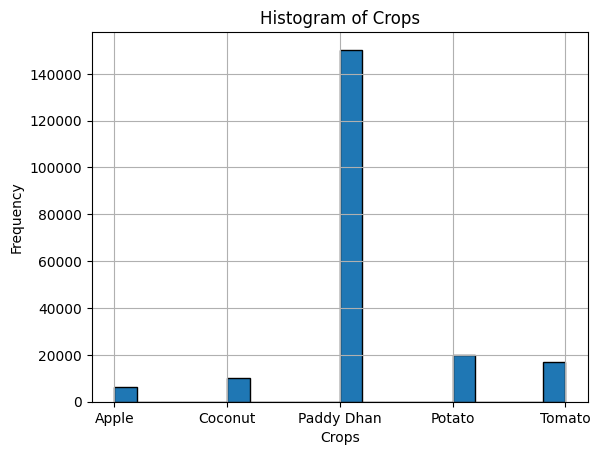

In [76]:
import matplotlib.pyplot as plt

# Histogram
big_df["Crop"].hist(bins=20, edgecolor="black")

plt.xlabel("Crops")
plt.ylabel("Frequency")
plt.title("Histogram of Crops")
plt.show()

In [60]:
big_df[big_df['KccAns'].str.isnumeric()]

,DistrictName,StateName,Season,Month,disease_name,QueryText,KccAns,Crop,word_count


In [ ]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

A = {"apple", "banana", "cherry"}
B = {"banana", "cherry", "date", "fig"}

print("Jaccard Similarity:", jaccard_similarity(A, B))  # 0.4

In [40]:
dataframe = pd.read_csv("filtered_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'filtered_data.csv'

In [ ]:
dataframe["Crop"] = dataframe["Crop"].replace("Paddy Dhan", "Paddy_Dhan")

In [ ]:
len(dataframe)

154081

In [ ]:
dataframe["Crop"].unique()

array(['Apple', 'Coconut', 'Paddy_Dhan', 'Potato', 'Tomato'], dtype=object)

In [ ]:
dataframe = dataframe.rename(columns={"Season English": "Season_English"})

In [ ]:
import calendar
dataframe["Month"] = dataframe["Month"].apply(lambda x: calendar.month_name[x])

In [ ]:
dataframe.head(2)

,Unnamed: 0,BlockName,Category,Year,Month,Day,Crop,DistrictName,QueryType,Season,...,StateName,QueryText,KccAns,latitude,longitude,Disease,kcc_word_count,QueryText_word_count,Season_English,BlockNamenew
0,0,0,0,2010,June,23,Apple,ANANTNAG,0,JAYAD,...,JAMMU AND KASHMIR,control of alternaria leaf blotch in apple tree,keep 60 cm soil around trees trunks undisturde...,33.7461,75.1854,Alternaria_leaf_blotch,9,8,Summer Cropping Season,0
1,1,0,0,2010,June,18,Apple,BARAMULLA,0,JAYAD,...,JAMMU AND KASHMIR,farmer wants information about the control of ...,the control of alternaria leaf blotch in apple...,34.2087,74.3435,Alternaria_leaf_blotch,19,13,Summer Cropping Season,0


In [ ]:
dataframe = dataframe[["DistrictName","StateName","Season_English","Month","Disease","QueryText","KccAns","Crop"]]

In [ ]:
dataframe.head(2)

NameError: name 'dataframe' is not defined

In [ ]:
len(dataframe)

154081

In [24]:
dataframe["KccAns"].unique()

NameError: name 'dataframe' is not defined

In [23]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

A = {"apple", "banana", "cherry"}
B = {"banana", "cherry", "date", "fig"}

print("Jaccard Similarity:", jaccard_similarity(A, B))  # 0.4

Jaccard Similarity: 0.4


In [28]:
dataframe.describe()

,DistrictName,StateName,Season_English,Month,Disease,QueryText,KccAns,Crop
count,154081,154081,61313,154081,154007,154081,154081,154081
unique,643,31,3,12,70,35903,110108,5
top,BARGARH,ODISHA,Monsoon Cropping Season,September,Dhan_stem_borer,stem borer in paddy,recommended to spray chlorantraniliprole corag...,Paddy_Dhan
freq,4873,29278,32725,32383,36535,5663,148,111609


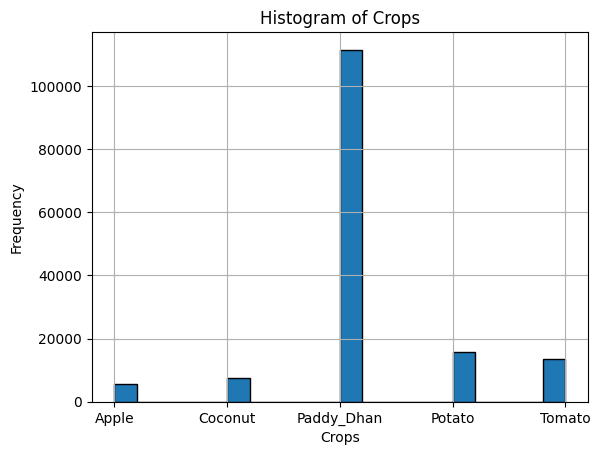

In [27]:
import matplotlib.pyplot as plt

# Histogram
dataframe["Crop"].hist(bins=20, edgecolor="black")

plt.xlabel("Crops")
plt.ylabel("Frequency")
plt.title("Histogram of Crops")
plt.show()

In [24]:
dataframe.isna().sum()

DistrictName          0
StateName             0
Season_English    92768
Month                 0
Disease              74
QueryText             0
KccAns                0
Crop                  0
dtype: int64

In [10]:
embedding = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large-instruct",model_kwargs={"device": "cuda"})
chroma_db = Chroma(
    persist_directory="./chroma_capstone_db_new",
    embedding_function=embedding,
    collection_name="Coconut"  # Specify which collection to load
)

: 

In [ ]:
import chromadb

# Connect to the same persisted DB
client = chromadb.PersistentClient(path="./chroma_capstone_db_new")

In [ ]:
collections = client.list_collections()

for c in collections:
    print(c.name)  

Tomato
